In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

In [2]:
data = pd.read_csv('./data/processed_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)

## Generate Feature

In [3]:
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['day_of_month'] = data.index.day
data['day_of_year'] = data.index.dayofyear
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['year'] = data.index.year

In [4]:
# data['peak_hour'] = (data['hour'] >= 8) & (data['hour'] <= 21)

In [5]:
data['peak_hour'] = 0

data.loc[((data['hour'] >= 8) & (data['hour'] <= 14)) |((data['hour'] >= 18) & (data['hour'] <= 21)),'peak_hour'] = 2

data.loc[(data['hour'] >= 15) & (data['hour'] <= 17),'peak_hour'] = 1

In [6]:
data['total load 1-month lag'] = data['total load actual'].shift(24*30)
data['total load 1-year lag']  = data['total load actual'].shift(24*365)

data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-month lag'])
data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-year lag'].mean())

data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-month lag'].mean())

In [7]:
# # data['total load 1-hour lag']   = data['total load actual'].shift(1)
# # data['total load 1-day lag']   = data['total load actual'].shift(24)
# data['total load 1-week lag']  = data['total load actual'].shift(24*7)
# data['total load 1-month lag'] = data['total load actual'].shift(24*30)
# data['total load 1-year lag']  = data['total load actual'].shift(24*365)

# data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-month lag'])
# data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-week lag'])
# # data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-day lag'])
# # data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-hour lag'])
# data['total load 1-year lag'] = data['total load 1-year lag'].fillna(data['total load 1-year lag'].mean())


# data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-week lag'])
# # data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-day lag'])
# # data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-hour lag'])
# data['total load 1-month lag'] = data['total load 1-month lag'].fillna(data['total load 1-month lag'].mean())

# # data['total load 1-week lag'] = data['total load 1-week lag'].fillna(data['total load 1-day lag'])
# # data['total load 1-week lag'] = data['total load 1-week lag'].fillna(data['total load 1-hour lag'])
# data['total load 1-week lag'] = data['total load 1-week lag'].fillna(data['total load 1-week lag'].mean())

# # data['total load 1-day lag'] = data['total load 1-day lag'].fillna(data['total load 1-hour lag'])
# # data['total load 1-day lag'] = data['total load 1-day lag'].fillna(data['total load 1-day lag'].mean())

# # data['total load 1-hour lag'] = data['total load 1-hour lag'].fillna(data['total load 1-hour lag'].mean())

In [8]:
data['avg_temp'] = np.mean(data[['temp_Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia']], axis=1)

In [10]:
X_col = [col for col in data.columns if ('forecast' not in col) and ('generation' not in col) and (col != 'total load actual')]
X = data[X_col]
y = data['total load actual']

In [12]:
train_percent = 0.8
train_size = int(0.8*len(X))

In [13]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [14]:
scaler_X.fit(X[:train_size])
scaler_y.fit(pd.DataFrame(y[:train_size]))

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [15]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(pd.DataFrame(y))

X_norm_train, y_norm_train = X_norm[:train_size], y_norm[:train_size]

## Check Feature Importance

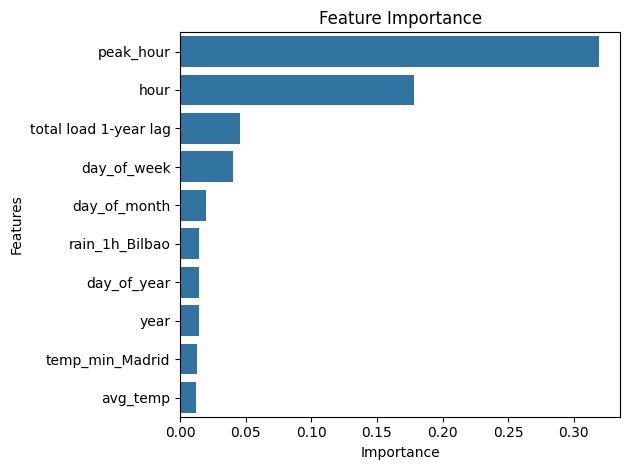

In [16]:
model = xgb.XGBRegressor()
model.fit(X_norm_train, y_norm_train)

importances = model.feature_importances_

# Plot the features importance using a barplot
feature_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.tight_layout()

In [17]:
feature_imp

peak_hour                                                  0.319379
hour                                                       0.178021
total load 1-year lag                                      0.045430
day_of_week                                                0.040296
day_of_month                                               0.019806
                                                             ...   
weather_description_heavy intensity rain_Seville           0.000000
weather_description_heavy intensity drizzle_Seville        0.000000
weather_description_haze_Seville                           0.000000
weather_description_ragged shower rain_Bilbao              0.000000
weather_description_light intensity drizzle rain_Madrid    0.000000
Length: 219, dtype: float32

In [18]:
X_norm_train, X_norm_test = X_norm[:train_size], X_norm[train_size:]
y_norm_train, y_norm_test = y_norm[:train_size], y_norm[train_size:]

In [19]:
# 3.2 Convert the data into DMatrix, which is a data storage used by XGBoost Algorithm, optimized for both memory efficiency and training speed
D_train = xgb.DMatrix(X_norm_train, label=y_norm_train)
D_test = xgb.DMatrix(X_norm_test, label=y_norm_test)

In [20]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import numpy as np

cv = TimeSeriesSplit(n_splits=15)

pipeline = Pipeline([
    ('selector', SelectFromModel(xgb.XGBRegressor(n_estimators=100, random_state=9))),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', nthread=-1))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid={
        'model__n_estimators': np.arange(70, 170, 20),
        'model__max_depth': [3, 4, 5],
        'model__learning_rate': np.arange(0.05, 0.15, 0.02),
    },
    cv=cv,
    scoring='explained_variance',
    verbose=3,
    error_score='raise'
)

grid.fit(X_norm_train, y_norm_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

# Predict
y_pred = grid.predict(X_norm_test)


Fitting 15 folds for each of 75 candidates, totalling 1125 fits
[CV 1/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.519 total time=   0.3s
[CV 2/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.552 total time=   0.4s
[CV 3/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.618 total time=   0.4s
[CV 4/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.664 total time=   0.4s
[CV 5/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.706 total time=   0.5s
[CV 6/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.687 total time=   0.5s
[CV 7/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.699 total time=   0.6s
[CV 8/15] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=70;, score=0.760 total time=   0.6s


In [21]:
selected_boolean = grid.best_estimator_['selector'].get_support()
selected_features = np.array(X.columns)[grid.best_estimator_['selector'].get_support()]
print("Selected Features: ", selected_features)

Selected Features:  ['temp_Barcelona' 'temp_max_Barcelona' 'rain_3h_Barcelona'
 'weather_description_fog_Barcelona'
 'weather_description_thunderstorm_Barcelona' 'temp_Bilbao'
 'pressure_Bilbao' 'rain_1h_Bilbao' 'rain_3h_Bilbao' 'snow_3h_Bilbao'
 'temp_Madrid' 'temp_min_Madrid' 'temp_max_Madrid' 'pressure_Madrid'
 'temp_min_Seville' 'rain_3h_Seville'
 'weather_description_few clouds_Seville'
 'weather_description_overcast clouds_Seville' 'temp_Valencia'
 'temp_min_Valencia' 'pressure_Valencia' 'rain_3h_Valencia' 'hour'
 'day_of_week' 'day_of_month' 'day_of_year' 'month' 'year' 'peak_hour'
 'total load 1-month lag' 'total load 1-year lag' 'avg_temp']


In [22]:
selected_features

array(['temp_Barcelona', 'temp_max_Barcelona', 'rain_3h_Barcelona',
       'weather_description_fog_Barcelona',
       'weather_description_thunderstorm_Barcelona', 'temp_Bilbao',
       'pressure_Bilbao', 'rain_1h_Bilbao', 'rain_3h_Bilbao',
       'snow_3h_Bilbao', 'temp_Madrid', 'temp_min_Madrid',
       'temp_max_Madrid', 'pressure_Madrid', 'temp_min_Seville',
       'rain_3h_Seville', 'weather_description_few clouds_Seville',
       'weather_description_overcast clouds_Seville', 'temp_Valencia',
       'temp_min_Valencia', 'pressure_Valencia', 'rain_3h_Valencia',
       'hour', 'day_of_week', 'day_of_month', 'day_of_year', 'month',
       'year', 'peak_hour', 'total load 1-month lag',
       'total load 1-year lag', 'avg_temp'], dtype=object)

In [23]:
best_params = grid.best_params_

print("best_params: ", best_params)
pipeline.set_params(**best_params)
pipeline.fit(X_norm_train, y_norm_train)


with open('xgboost_with_monthly_lag_no_generation_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# # Load the pipeline later
# with open('xgboost_with_monthly_lag_pipeline.pkl', 'rb') as f:
#     loaded_pipeline = pickle.load(f)

# # You can then access the XGBoost model and its parameters
# print(loaded_pipeline.named_steps['model'].get_params())

best_params:  {'model__learning_rate': np.float64(0.07), 'model__max_depth': 5, 'model__n_estimators': np.int64(130)}


## Check Model Results

In [24]:
train_pred_y = pipeline.predict(X_norm_train)
test_pred_y = pipeline.predict(X_norm_test)

In [25]:
true_test_y = scaler_y.inverse_transform(y_norm_test)
true_train_y = scaler_y.inverse_transform(y_norm_train)
true_pred_train_y = scaler_y.inverse_transform(train_pred_y.reshape(-1, 1))
true_pred_y = scaler_y.inverse_transform(test_pred_y.reshape(-1, 1))

In [26]:
print("Training Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(true_train_y, true_pred_train_y)*100))
print("Testing Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(true_test_y, true_pred_y)*100))

Training Mean Absolute Percentage Error: 4.142375412598502
Testing Mean Absolute Percentage Error: 5.089204992171767


In [27]:
train_mse = mean_squared_error(true_train_y, true_pred_train_y)
train_var_y = np.var(true_pred_train_y)
train_explained_var = 1 - train_mse / train_var_y

test_mse = mean_squared_error(true_test_y, true_pred_y)
test_var_y = np.var(true_pred_y)
test_explained_var = 1 - test_mse / test_var_y

print("Training Explained Variance:", train_explained_var)
print("Testing Explained Variance:", test_explained_var)


Training Explained Variance: 0.8404091
Testing Explained Variance: 0.74210393


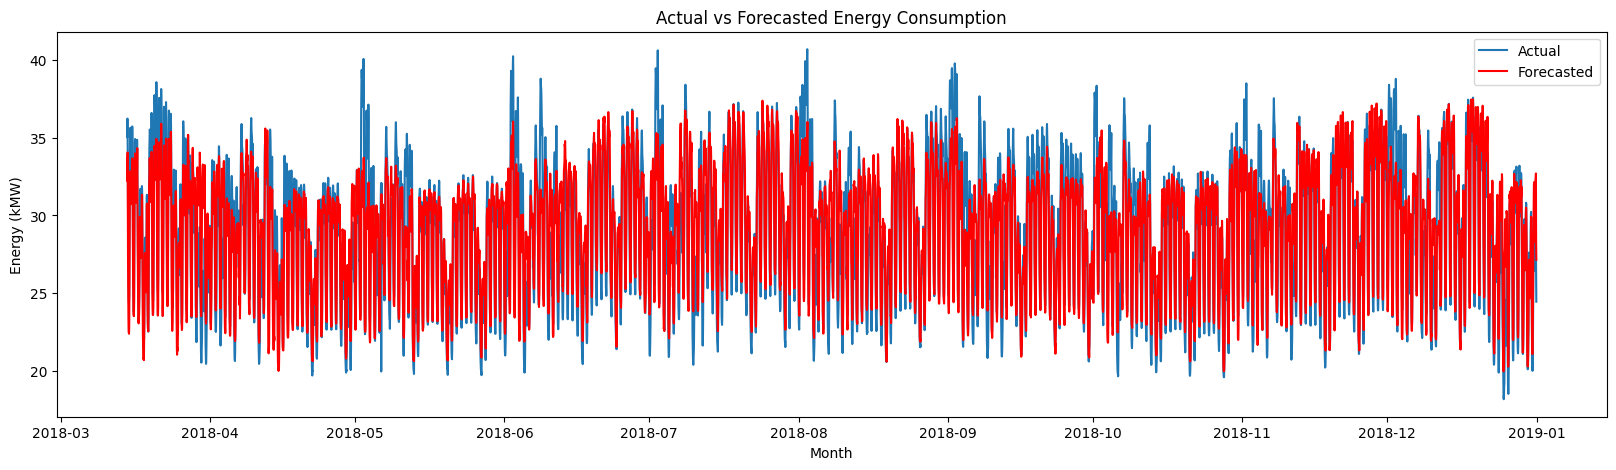

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(y[train_size:].index, true_test_y/1000, label='Actual')
plt.plot(y[train_size:].index, true_pred_y/1000, label='Forecasted', color='red')
plt.title("Actual vs Forecasted Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Energy (kMW)")
plt.legend()
plt.show()


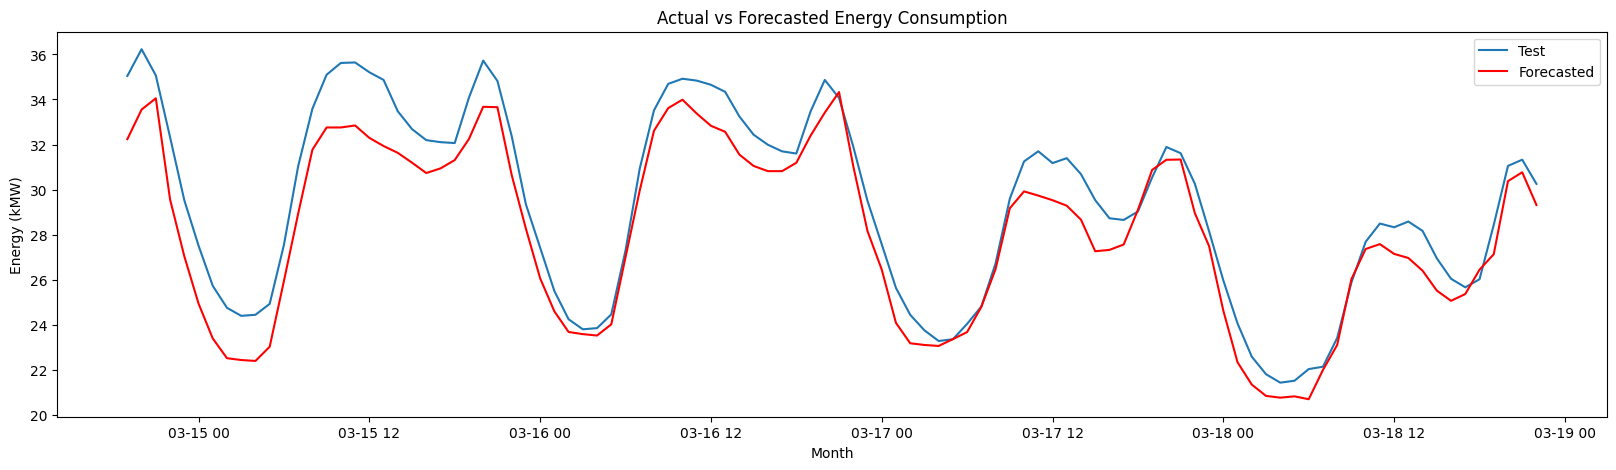

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(y[train_size:train_size+100].index, true_test_y[:100]/1000, label='Test')
plt.plot(y[train_size:train_size+100].index, true_pred_y[:100]/1000, label='Forecasted', color='red')
plt.title("Actual vs Forecasted Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Energy (kMW)")
plt.legend()
plt.show()


In [30]:
plt.figure(figsize=(40, 20), dpi=1000)  # large and high DPI
xgb.plot_tree(pipeline['model'], num_trees=0, rankdir='TB')
plt.savefig("xgb_tree_291201.png", dpi=1000, bbox_inches='tight')
plt.close()

/usr/local/lib/python3.11/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 40000x20000 with 0 Axes>

In [31]:
selected_features

array(['temp_Barcelona', 'temp_max_Barcelona', 'rain_3h_Barcelona',
       'weather_description_fog_Barcelona',
       'weather_description_thunderstorm_Barcelona', 'temp_Bilbao',
       'pressure_Bilbao', 'rain_1h_Bilbao', 'rain_3h_Bilbao',
       'snow_3h_Bilbao', 'temp_Madrid', 'temp_min_Madrid',
       'temp_max_Madrid', 'pressure_Madrid', 'temp_min_Seville',
       'rain_3h_Seville', 'weather_description_few clouds_Seville',
       'weather_description_overcast clouds_Seville', 'temp_Valencia',
       'temp_min_Valencia', 'pressure_Valencia', 'rain_3h_Valencia',
       'hour', 'day_of_week', 'day_of_month', 'day_of_year', 'month',
       'year', 'peak_hour', 'total load 1-month lag',
       'total load 1-year lag', 'avg_temp'], dtype=object)

---

## Load and Check trained Model

Monthly lag included

In [32]:
with open('xgboost_with_monthly_lag_no_generation_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

loaded_pipeline.fit(X_norm_train, y_norm_train)

train_pred_y = loaded_pipeline.predict(X_norm_train)
test_pred_y = loaded_pipeline.predict(X_norm_test)

print("Training Mean Squared Error: {}".format(mean_squared_error(y_norm_train, train_pred_y)))
print("Testing Mean Squared Error: {}".format(mean_squared_error(y_norm_test, test_pred_y)))

Training Mean Squared Error: 0.004986453232418532
Testing Mean Squared Error: 0.007543747712524117


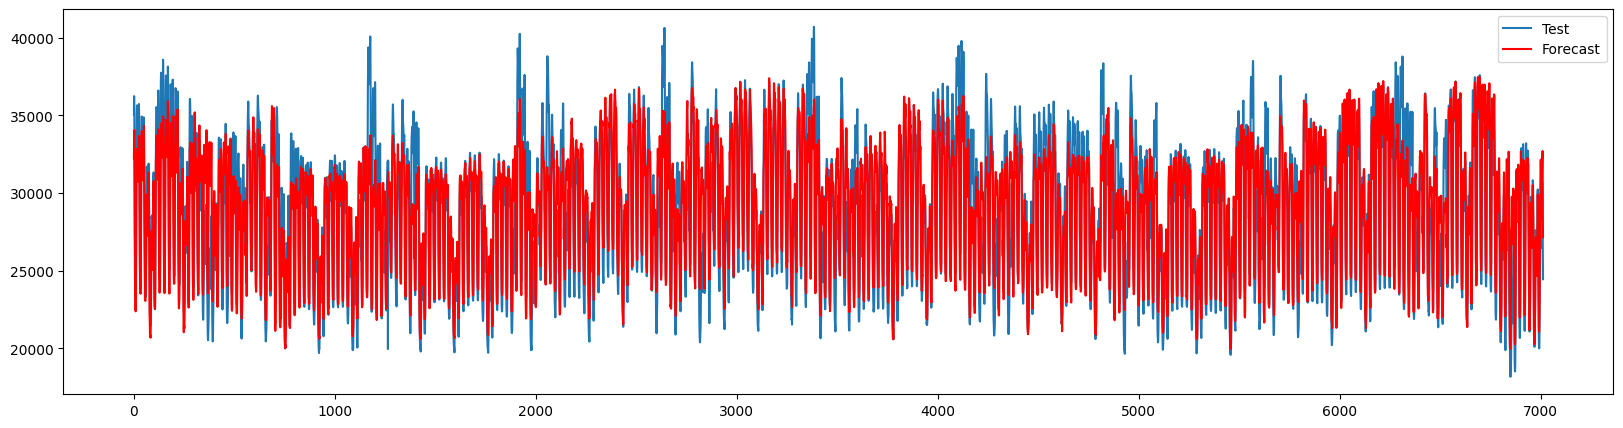

In [33]:
plt.figure(figsize=(20, 5))
plt.plot(true_test_y, label='Test')
plt.plot(true_pred_y, label='Forecast', color='red')
plt.legend()
plt.show()

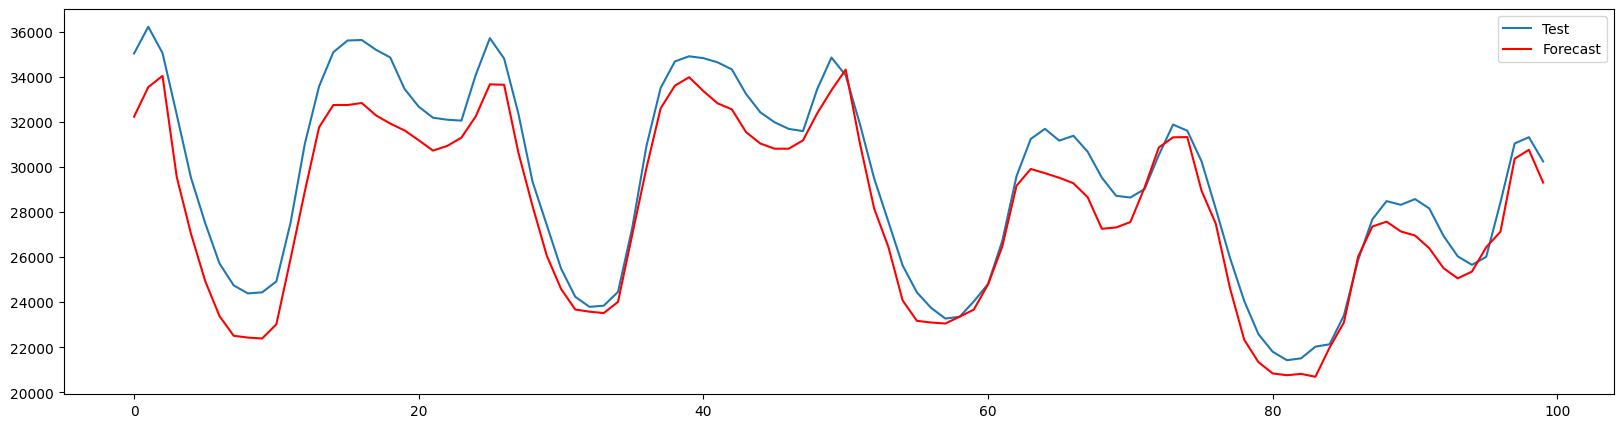

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(true_test_y[:100], label='Test')
plt.plot(true_pred_y[:100], label='Forecast', color='red')
plt.legend()
plt.show()

In [35]:
train_mse = mean_squared_error(true_train_y, true_pred_train_y)
train_var_y = np.var(true_pred_train_y)
train_explained_var = 1 - train_mse / train_var_y

test_mse = mean_squared_error(true_test_y, true_pred_y)
test_var_y = np.var(true_pred_y)
test_explained_var = 1 - test_mse / test_var_y

print("Training Explained Variance:", train_explained_var)
print("Testing Explained Variance:", test_explained_var)


Training Explained Variance: 0.8404091
Testing Explained Variance: 0.74210393
